## Exercise 04.1

In questo esercizio usiamo un codice di dinamica molecolare (MD) per stimare le proprietà macroscopiche di solidi, liquidi e gas.

### Premesse

1. Si considera l'ensemble microcanico (NVE, ovvero numero di particelle, volume e energia fissati): tutti gli stati  uguale energia è ugualmente probabile.

2. Si considera il potenziale di interazione di Lennard-Jones, dato da

 $$V = 4 \epsilon \bigg[\big(\frac{\sigma}{r}\big)^{12} - \big(\frac{\sigma}{r}\big)^6 \bigg] $$
 
3. L'algoritmo utilizzato è quello di Verlet.


### Algoritmo di Verlet

#### -Caratteristiche generali

L'algoritmo di Verlet fornito simula la dinamica di un sistema di $N=108$ particelle che interagiscono attraverso un particolare potenziale (nel nostro caso Lennard-Jones). L'algoritmo è in grado di misurare l'energia totale per particella $E/N$, l'energia potenziale per particella $U/N$, l'energia cinetica per particella $K/N$ e di ricavare da questa la temperatura $T$.

L'algoritmo funziona fissando alcuni parametri, come la densità $\rho$ della sostanza, il raggio di cutoff $r_{cut}$ (distanza minima stabilita per il calcolo del potenziale di interazione tra due particlle), la temperatura $t$ di partenza che permette di generare in modo casuale la configurazione iniziale e il passo $\delta$.

#### -Funzionamento

L'algoritmo integra le equazioni del moto utilizzando l'insieme delle posizioni al tempo presente e nell'instate immediatamente precedente. La nuova posizione è approssimata come:

$$ \vec{r}(t+\delta t) \approx 2\vec{r}(t)-\vec{r}(t-\delta t)+\delta t^2\vec{a}(t) $$

Evidentemente la conoscenza di posizione e velocità iniziali non è sufficiente per per far partire l'algoritmo. Per questo si interpolano delle posizioni associate all'istante precedente calcolando la quantità $\vec{r}_{old}=\vec{r}-\vec{v}\delta t$. Se l'algoritmo viene usato per la prima volta è necessario generare un insieme di posizioni da cui far evolvere il sistema (le velocità vengono generate a partire dalla temperatura iniziale passata come parametro). Se invece l'algoritmo è già stato utilizzato, questo produce due file, contenti l'insieme delle posizioni e delle velocità che possono essere lette e utilizzate per una nuova simulazione.

Come ultima osservazione sull'algoritmo, specifichiamo che conserva l'energia totale del sistema e che quindi è adeguato per fare simulazioni NVE.

#### Condizioni al contorno periodiche (PBC)

Una simulazione che utilizza un numero di particelle $\sim N_A\sim 10^{23}$ non è possibile in tempi sensati. Per questo si immagina di averne un numero ridotto (nel nostro caso $N=108$) in una scatola, caratterizzata da condizioni periodiche ai bordi. Quindi ogni volta che una particella esce da un lato, viene riammessa nella scatola dal lato opposto con la stessa velocità.


### Svolgimento 

Al codice è stato aggiunto il calcolo della pressione $P$, la quale è espressa mediante il teorema del viriale come: 

$$ P = \rho k_B T + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\epsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle
= \rho T + \frac{\langle W \rangle}{3V}
$$

Nell'algoritmo si utilizzano unità di misura ridotte per cui $E=\epsilon E^*$, $V=\epsilon V^*$, $K=\epsilon K^*$, $T=\epsilon/k_b T^*$ and  $P=\epsilon/\sigma^3P^*$. Vengono in realtà sempre utilizzate queste grandezze e il calcolo è implementato per $P^*$.

A livello di algoritmo, questo passaggio viene fatto piuttosto agilmente aggiungendo un accumulatore per il viriale $W$, il quale viene poi riscalato di una fattore $\frac{1}{3V}$.

### Termalizzazione

L'algoritmo Verlet conserva l'energia totale e non la temperatura, quindi a priori non ci dobbiamo aspettare che alla configurazione con cui parte la simulazione sia associata la temperatura di equilibrio.
Può per esempio succedere di voler simulare una fase liquida partendo da una configurazione cristallina: l'energia potenziale aumenta e di conseguenza l'energia cinetica diminuisce, facendo così diminuire anche la temperatura.

Per questo la prima fase della simulazione consiste nel trovare (con prove ed errori) i valori di temperatura da impostare per arrivare alla temperatura di termalizzazione a cui si vuole simulare il sistema. Si sono trovati i seguenti risultati:

1. Fase gassosa: $T_{target}=1.2$, $T_{start}=0.95$
2. Fase liquida: $T_{target}=1.1$, $T_{start}=2.00$
3. Fase solida: $T_{target}=0.8$, $T_{start}=1.54$

Gli altri parametri sono stati fissati nel seguente modo:
 
1. Fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c = 5.0$)
2. Fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c = 2.5$)
3. Fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c = 2.2$)

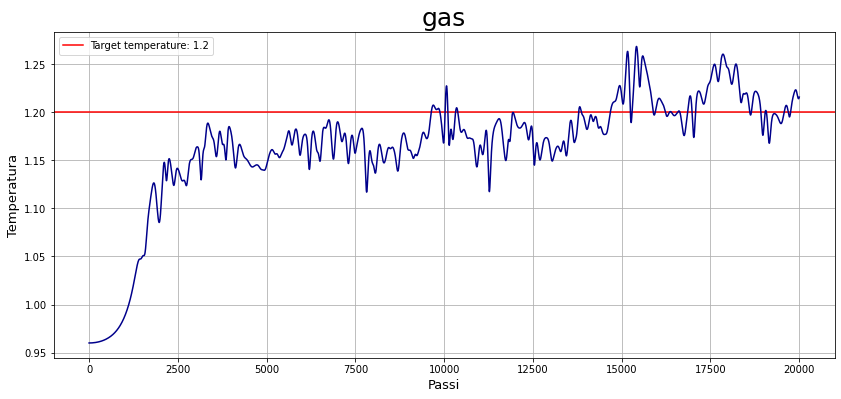

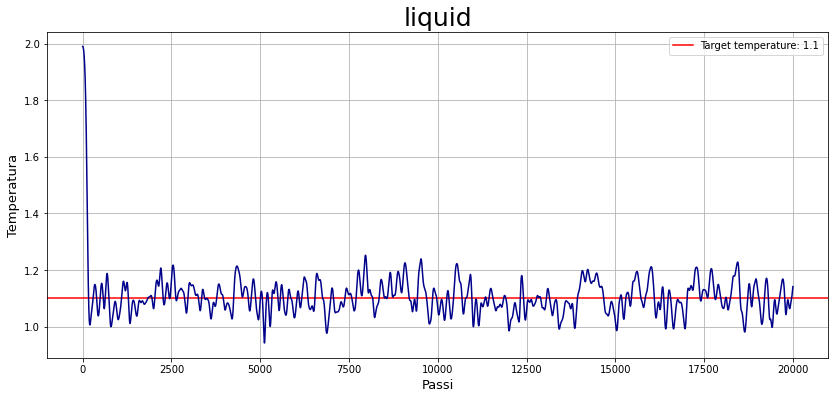

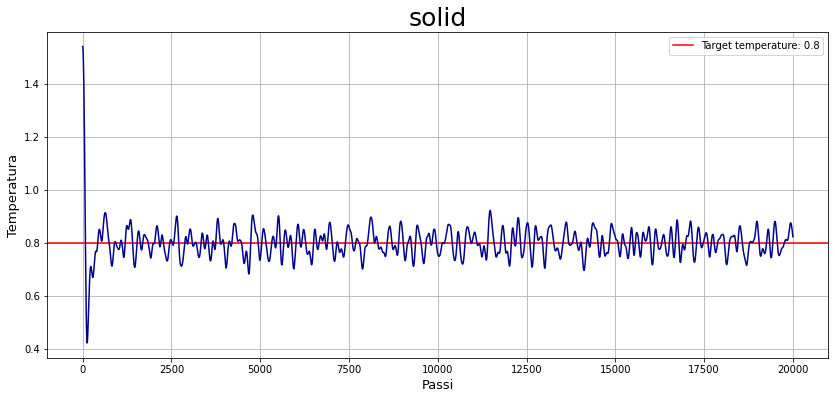

In [4]:
import numpy as np
import matplotlib.pyplot as plt

Teq = [ 1.2, 1.1, 0.8 ]
phase = ["gas", "liquid", "solid" ]


for i in range (0,3) :
    x, temp, temp_prog, err_prog = np.loadtxt("MDNVE_MCNVT/output/"+phase[i]+"/eq/output_temp.dat", unpack=True)
    plt.figure(figsize=(14,6))
    plt.axhline(y=Teq[i], color ="r", label = "Target temperature: "+str(Teq[i]))
    plt.plot(x,temp, color="darkblue")
    plt.title(phase[i], fontsize=25)
    plt.xlabel('Passi', fontsize=13)
    plt.ylabel('Temperatura', fontsize=13)
    plt.grid(True)
    plt.legend()
    plt.show()

Dai grafici risulta evidente che la termalizzazione avviene molto più velocemente per la fase liquida e per quella solida (intorno ai 2000 passi già c'è convergenza), mentre per quella gassosa avviene su tempi dieci volte circa più lunghi (20000 passi).

## Exercise 04.2

In questa parte dell'esercizio consideriamo l'Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu).

Mostriamo i valori della media a blocchi per le quantità termodinamiche di interesse, in unità ridotte (con il miglior risultato riportato poi in unità SI) e per tutte le tre fasi considerate.

Per mettere in evidenza come l'energia totale sia conservata dall'algoritmo, si è deciso di mostrare il quel particolare grafico utilizzando una scala analoga a quella dell'energia cinetica e potenziale.

In [61]:
Tscala=1
Escala=1
Pscala=1

Tscala_f=120.
Escala_f=120.*1.381E-23
Pscala_f=120.*1.381E-23*(10**6/0.34)**3

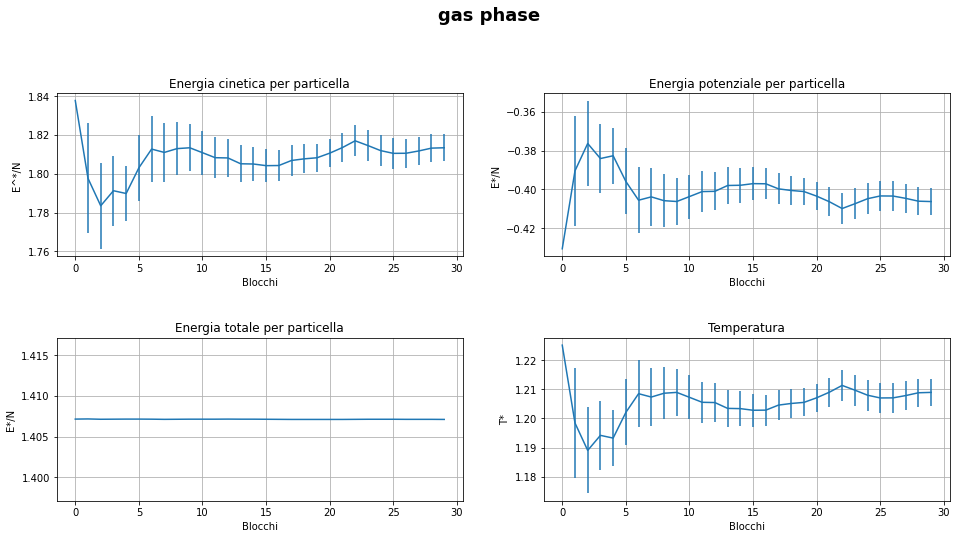

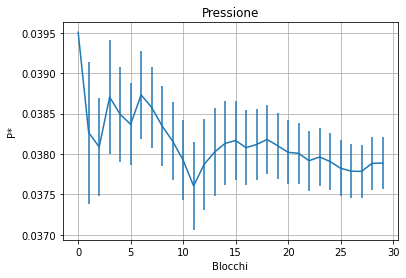

---Stime finali---
Energia cinetica    3.0051167639999996e-21 ± 1.1638233875999999e-23  J
Energia potenziale  -6.73229214e-22 ± 1.1642194584e-23  J
Energia totale      2.331879264e-21 ± 2.5967329679999996e-26  J
Temperatura         145.0692 ± 0.5618256  K
Pressione           0.0015974414624465702 ± 1.3393071799307958e-05  Pa


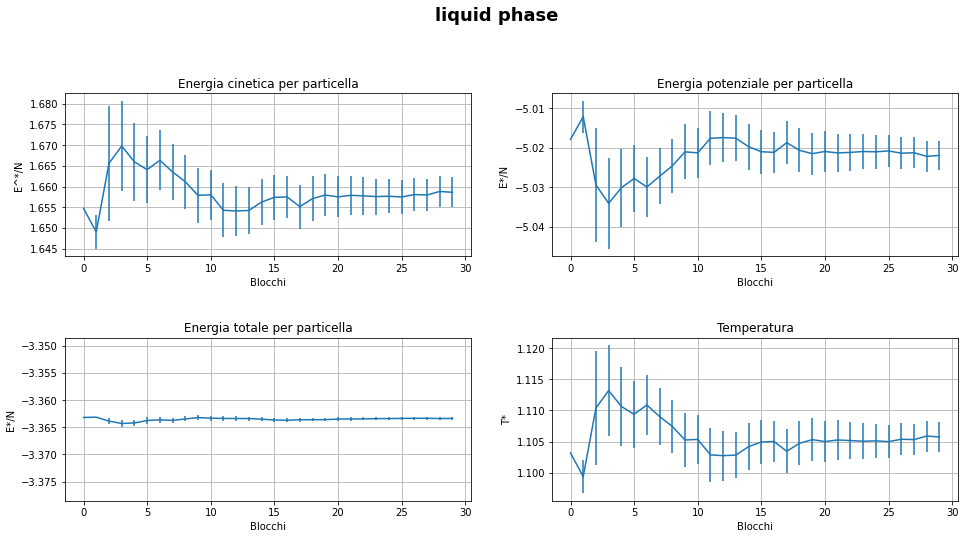

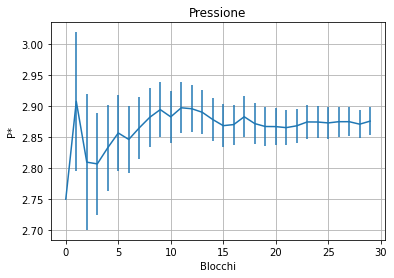

---Stime finali---
Energia cinetica    2.7486484919999997e-21 ± 5.985856116e-24  J
Energia potenziale  -8.322425256e-21 ± 6.206943168e-24  J
Energia totale      -5.573776764e-21 ± 3.776410788e-25  J
Temperatura         132.6888 ± 0.2889624  K
Pressione           0.1212470495623855 ± 0.000958152023203745  Pa


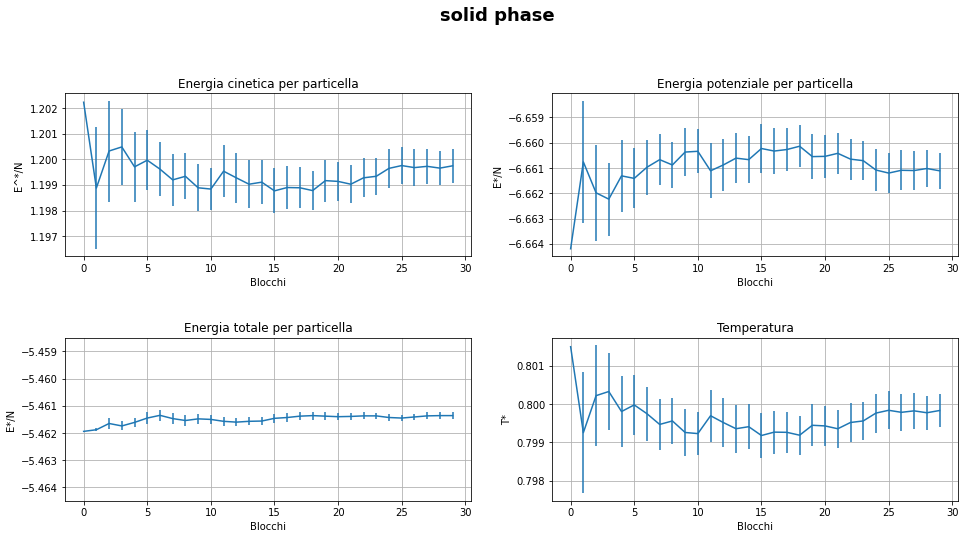

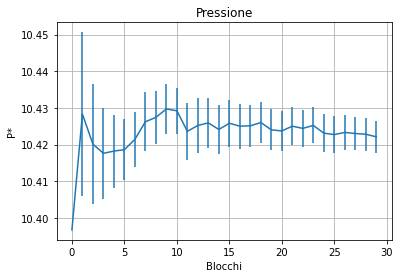

---Stime finali---
Energia cinetica    1.9882257e-21 ± 1.0894250508e-24  J
Energia potenziale  -1.1038791491999999e-20 ± 1.1883300611999999e-24  J
Energia totale      -9.050565792e-21 ± 1.9769070239999998e-25  J
Temperatura         95.97972 ± 0.0525912  K
Pressione           0.43943375025442694 ± 0.0001847433944636678  Pa


In [59]:
delE=[0.01, 0.015, 0.003]

for i in range (0,3):

    K, errK = Escala*np.loadtxt('MDNVE_MCNVT/output/'+phase[i]+'/output_ekin.dat',unpack=True,usecols=(2,3))
    T, errT = Tscala*np.loadtxt('MDNVE_MCNVT/output/'+phase[i]+'/output_temp.dat',unpack=True,usecols=(2,3))
    V, errV = Escala*np.loadtxt('MDNVE_MCNVT/output/'+phase[i]+'/output_epot.dat',unpack=True,usecols=(2,3))
    E, errE = Escala*np.loadtxt('MDNVE_MCNVT/output/'+phase[i]+'/output_etot.dat',unpack=True,usecols=(2,3))
    P, errP = Pscala*np.loadtxt('MDNVE_MCNVT/output/'+phase[i]+'/output_pres.dat',unpack=True,usecols=(2,3))


    passi = np.arange(K.size)

    plt.figure(figsize=(16,12))
    plt.suptitle(phase[i]+' phase',fontweight='bold', fontsize=18)

    plt.subplot(321)
    plt.errorbar(passi,K,errK)
    plt.title('Energia cinetica per particella')
    plt.xlabel('Blocchi')
    plt.ylabel('E^*/N ')
    plt.grid(True)

    plt.subplot(322)
    plt.errorbar(passi,V,errV)
    plt.title('Energia potenziale per particella')
    plt.xlabel('Blocchi')
    plt.ylabel('E*/N ')
    plt.grid(True)
    plt.subplots_adjust(hspace=0.5)  #

    plt.subplot(323)
    plt.errorbar(passi,E,errE)
    plt.title('Energia totale per particella')
    plt.xlabel('Blocchi')
    plt.ylabel('E*/N ')
    plt.ylim(E.mean()-delE[i], E.mean()+delE[i])
    plt.grid(True)

    plt.subplot(324)
    plt.errorbar(passi,T,errT)
    plt.title('Temperatura')
    plt.xlabel('Blocchi')
    plt.ylabel('T*')
    plt.grid(True)
    plt.show()
    
    plt.errorbar(passi,P,errP)
    plt.title('Pressione')
    plt.xlabel('Blocchi')
    plt.ylabel('P*')
    plt.grid(True)
    plt.show()

    print('---Stime finali---')
    print('Energia cinetica   ',Escala_f*K[K.size-1],'±',Escala_f*errK[K.size-1],' J')
    print('Energia potenziale ',Escala_f*V[V.size-1],'±',Escala_f*errV[V.size-1],' J')
    print('Energia totale     ',Escala_f*E[E.size-1],'±',Escala_f*errE[E.size-1],' J')
    print('Temperatura        ',Tscala_f*T[T.size-1],'±',Tscala_f*errT[T.size-1],' K')
    print('Pressione          ',Pscala_f*P[P.size-1],'±',Pscala_f*errP[P.size-1],' Pa')